In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd

import data_pre_processing
import dataset_pre_processing
import pre_training
import raw_data_processing
from raw_data_processing import process_PAMAP2_all_data, process_hhar_all_files, process_motion_sense_all_files, open_pickle
import numpy as np
import scipy.stats
import data_pre_processing
import self_har_models
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

tf.get_logger().setLevel('INFO')

# Data pre-processing

In [2]:
# get data from pickle 

with open('pickled_datasets/pamap.pickle', 'rb') as file:
    pamap_df = pickle.load(file)
with open('pickled_datasets/hhar.pickle', 'rb') as file:
    hhar_df = pickle.load(file)
with open('pickled_datasets/motionsense.pickle', 'rb') as file:
    motion_sense_df = pickle.load(file)
    
def concat_datasets(datasets, sensor_type):
    concated_datasets = {}
    ##TODO need to check key to see whether mag exists
    for df in datasets:
        concated_datasets.update(df[sensor_type])
    return concated_datasets

cdf = concat_datasets([pamap_df, hhar_df, motion_sense_df], "acc")
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(cdf)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
    cdf, label_map, 6, 
    ['101', '102', '103', '104', '105', '106', '107', 'a', 'b', 'c', 'd', 'e', 'f', 'g', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'], 
    ["108", "109", "h", "i", "21", "22", "23", "24"], 400, 200
)

{'IMU ankle': 0, 'IMU chest': 1, 'IMU hand': 2, 'Phone': 3, 'Watch': 4, 'iphone': 5}
getting mean
[-0.18597652  1.40292431  4.05411898]
[6.31367612 5.0870368  5.47022979]
normalising train set
normalisnig test


# Create a CNN Model

In [3]:
test_model = self_har_models.create_1d_conv_core_model((400,3), "HAR")
cnn_model = self_har_models.attach_full_har_classification_head(test_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
cnn_history = cnn_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

Epoch 1/10
2499/2499 [==============================] - 14s 5ms/step - loss: 0.1970 - categorical_accuracy: 0.9441 - auc: 0.9945 - precision: 0.9491 - recall: 0.9386 - val_loss: 0.1912 - val_categorical_accuracy: 0.9485 - val_auc: 0.9960 - val_precision: 0.9583 - val_recall: 0.9425
Epoch 2/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1410 - categorical_accuracy: 0.9590 - auc: 0.9970 - precision: 0.9612 - recall: 0.9565 - val_loss: 0.1475 - val_categorical_accuracy: 0.9586 - val_auc: 0.9973 - val_precision: 0.9636 - val_recall: 0.9556
Epoch 3/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1227 - categorical_accuracy: 0.9652 - auc: 0.9977 - precision: 0.9673 - recall: 0.9633 - val_loss: 0.1714 - val_categorical_accuracy: 0.9464 - val_auc: 0.9967 - val_precision: 0.9526 - val_recall: 0.9416
Epoch 4/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1107 - categorical_accuracy: 0.9698 - auc: 0.9979 - precision: 0.9714 - 

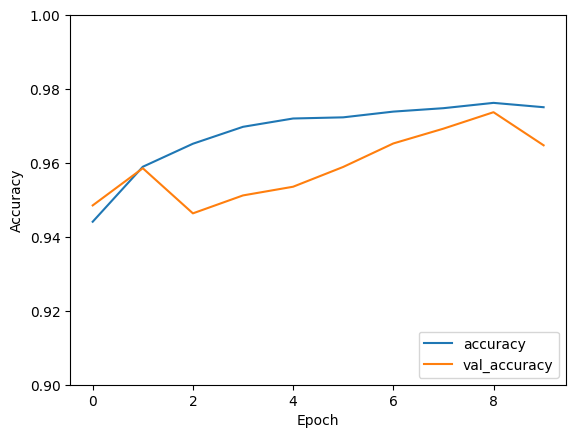

660/660 [==============================] - 1s 2ms/step


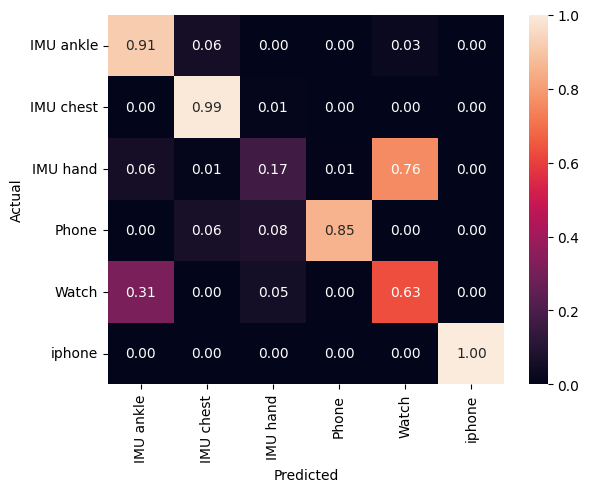

In [4]:
import matplotlib.pyplot as plt
plt.plot(cnn_history.history['categorical_accuracy'], label='accuracy')
plt.plot(cnn_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

cnn_test_result = cnn_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)

predicted_labels = np.argmax(cnn_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Create LSTM-Model

In [5]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='sigmoid')(x)
LSTM_model = tf.keras.Model(inputs, x, name="LSTM-CNN")
print(LSTM_model.summary())
full_LSTM_model = self_har_models.attach_full_har_classification_head(LSTM_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
LSTM_history = full_LSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

Model: "LSTM-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 192)              76800     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 96)                18528     
                                                                 
 dense_3 (Dense)             (None, 100)               9700      
                                                                 
Total params: 105,028
Trainable params: 105,028
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2499/2499 [==============================] - 64s 25ms/step - loss: 0.3089 - categorical_accuracy: 0.90

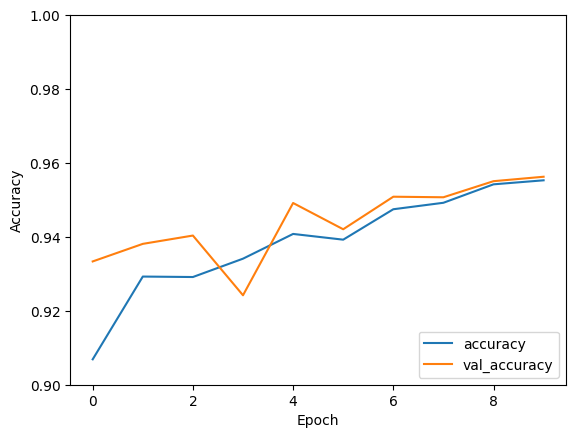

660/660 [==============================] - 8s 12ms/step


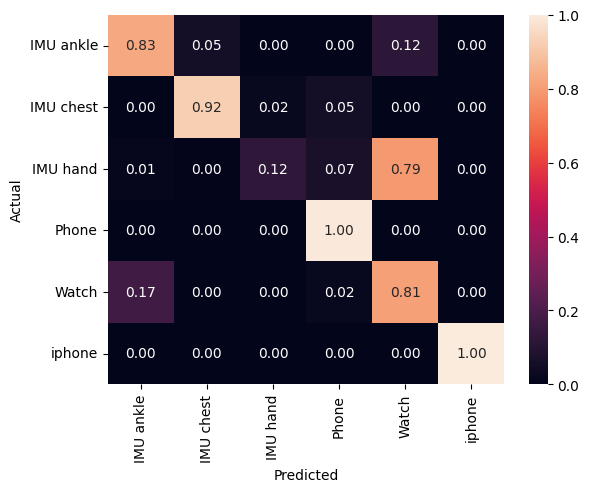

In [6]:
import matplotlib.pyplot as plt
plt.plot(LSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(LSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_LSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_LSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [7]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Dense(300, activation='relu')(x)
x = tf.keras.layers.Conv1D(
        64, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Conv1D(
        128, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Conv1D(
    128, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Conv1D(
    256, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='softmax')(x)

CNNLSTN_model = tf.keras.Model(inputs, x, name="CNN-LSTM")
print(CNNLSTN_model.summary())

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 dense_6 (Dense)             (None, 400, 300)          1200      
                                                                 
 conv1d_3 (Conv1D)           (None, 398, 64)           57664     
                                                                 
 conv1d_4 (Conv1D)           (None, 396, 128)          24704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 197, 128)         0         
 )                                                               
                                                                 
 conv1d_5 (Conv1D)           (None, 97, 128)           82048     
                                                          

In [8]:
full_CNNLSTM_model = self_har_models.attach_full_har_classification_head(CNNLSTN_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM_history = full_CNNLSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

Epoch 1/10
2499/2499 [==============================] - 27s 10ms/step - loss: 0.4221 - categorical_accuracy: 0.8555 - auc: 0.9812 - precision: 0.9031 - recall: 0.8220 - val_loss: 0.2285 - val_categorical_accuracy: 0.9499 - val_auc: 0.9900 - val_precision: 0.9503 - val_recall: 0.9493
Epoch 2/10
2499/2499 [==============================] - 23s 9ms/step - loss: 0.2155 - categorical_accuracy: 0.9438 - auc: 0.9930 - precision: 0.9472 - recall: 0.9407 - val_loss: 0.2284 - val_categorical_accuracy: 0.9362 - val_auc: 0.9927 - val_precision: 0.9483 - val_recall: 0.9321
Epoch 3/10
2499/2499 [==============================] - 23s 9ms/step - loss: 0.1921 - categorical_accuracy: 0.9506 - auc: 0.9943 - precision: 0.9536 - recall: 0.9479 - val_loss: 0.1630 - val_categorical_accuracy: 0.9558 - val_auc: 0.9965 - val_precision: 0.9584 - val_recall: 0.9544
Epoch 4/10
2499/2499 [==============================] - 23s 9ms/step - loss: 0.1674 - categorical_accuracy: 0.9576 - auc: 0.9958 - precision: 0.9593 -

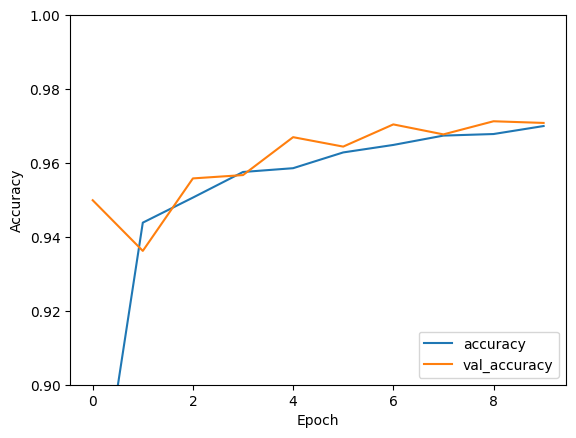

660/660 [==============================] - 2s 3ms/step


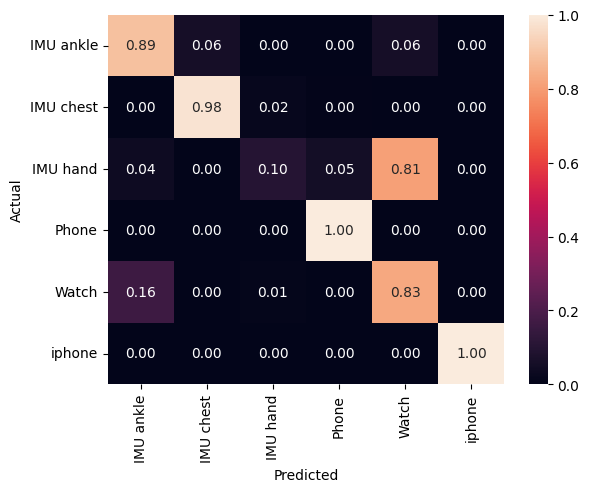

In [9]:
import matplotlib.pyplot as plt
plt.plot(CNNLSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Try another CNN-LSTM Model

In [10]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Dense(300, activation='relu')(x)
x = tf.keras.layers.Conv1D(
        64, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Conv1D(
        128, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Conv1D(
    128, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Conv1D(
    256, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300))(x)
x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='softmax')(x)

CNNLSTN2_model = tf.keras.Model(inputs, x, name="CNN-LSTM")
print(CNNLSTN2_model.summary())

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 dense_10 (Dense)            (None, 400, 300)          1200      
                                                                 
 conv1d_7 (Conv1D)           (None, 398, 64)           57664     
                                                                 
 conv1d_8 (Conv1D)           (None, 396, 128)          24704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 197, 128)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 97, 128)           82048     
                                                          

In [11]:
full_CNNLSTM2_model = self_har_models.attach_full_har_classification_head(CNNLSTN2_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM2_history = full_CNNLSTM2_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

Epoch 1/10
2499/2499 [==============================] - 30s 11ms/step - loss: 0.4438 - categorical_accuracy: 0.8629 - auc: 0.9794 - precision: 0.9046 - recall: 0.8273 - val_loss: 0.2511 - val_categorical_accuracy: 0.9419 - val_auc: 0.9904 - val_precision: 0.9440 - val_recall: 0.9387
Epoch 2/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2639 - categorical_accuracy: 0.9363 - auc: 0.9901 - precision: 0.9399 - recall: 0.9331 - val_loss: 0.2426 - val_categorical_accuracy: 0.9431 - val_auc: 0.9914 - val_precision: 0.9454 - val_recall: 0.9408
Epoch 3/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2353 - categorical_accuracy: 0.9404 - auc: 0.9924 - precision: 0.9435 - recall: 0.9377 - val_loss: 0.2144 - val_categorical_accuracy: 0.9480 - val_auc: 0.9934 - val_precision: 0.9494 - val_recall: 0.9467
Epoch 4/10
2499/2499 [==============================] - 26s 10ms/step - loss: 0.2104 - categorical_accuracy: 0.9441 - auc: 0.9937 - precision: 0.948

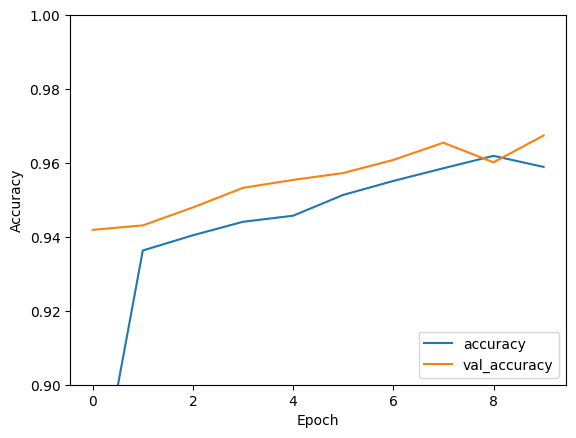

660/660 [==============================] - 3s 3ms/step


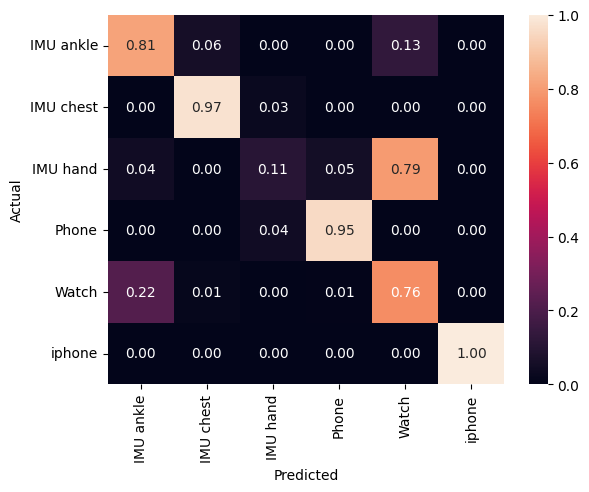

In [12]:

plt.plot(CNNLSTM2_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM2_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM2_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM2_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# LSTM-CNN Model

In [3]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True, return_state=True))(x)
x = tf.keras.layers.LSTM(300, return_sequences=True)(x)
x = tf.keras.layers.LSTM(300, return_sequences=True)(x)
x = tf.keras.layers.Conv1D(
        32, 24,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
        64, 16,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
    96, 8,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.GlobalMaxPool1D(data_format='channels_last', name='global_max_pooling1d')(x) 

LSTMCNN_model = tf.keras.Model(inputs, x, name="LSTM-CNN")
print(LSTMCNN_model.summary())

Model: "LSTM-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 400, 300)          364800    
                                                                 
 lstm_1 (LSTM)               (None, 400, 300)          721200    
                                                                 
 conv1d (Conv1D)             (None, 377, 32)           230432    
                                                                 
 dropout (Dropout)           (None, 377, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 362, 64)           32832     
                                                                 
 dropout_1 (Dropout)         (None, 362, 64)           0  

In [4]:
full_LSTMCNN_model = self_har_models.attach_full_har_classification_head(LSTMCNN_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
LSTMCNN_history = full_LSTMCNN_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

Epoch 1/10
2499/2499 [==============================] - 122s 47ms/step - loss: 0.2491 - categorical_accuracy: 0.9301 - auc: 0.9921 - precision: 0.9395 - recall: 0.9227 - val_loss: 0.1943 - val_categorical_accuracy: 0.9497 - val_auc: 0.9966 - val_precision: 0.9618 - val_recall: 0.9396
Epoch 2/10
2499/2499 [==============================] - 117s 47ms/step - loss: 0.1710 - categorical_accuracy: 0.9512 - auc: 0.9960 - precision: 0.9546 - recall: 0.9477 - val_loss: 0.1416 - val_categorical_accuracy: 0.9576 - val_auc: 0.9979 - val_precision: 0.9614 - val_recall: 0.9535
Epoch 3/10
2499/2499 [==============================] - 117s 47ms/step - loss: 0.1431 - categorical_accuracy: 0.9582 - auc: 0.9970 - precision: 0.9607 - recall: 0.9560 - val_loss: 0.1327 - val_categorical_accuracy: 0.9646 - val_auc: 0.9980 - val_precision: 0.9700 - val_recall: 0.9591
Epoch 4/10
2499/2499 [==============================] - 117s 47ms/step - loss: 0.1273 - categorical_accuracy: 0.9633 - auc: 0.9975 - precision: 0

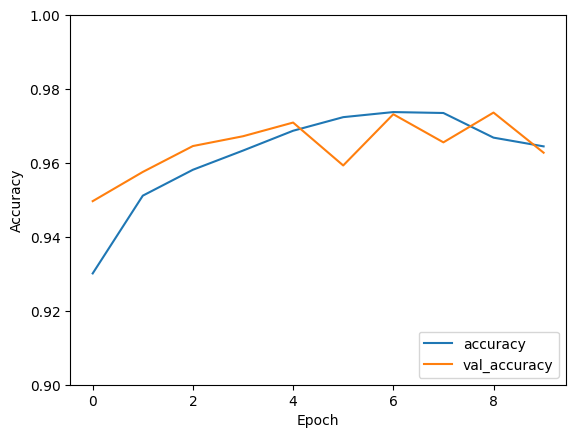

660/660 [==============================] - 10s 14ms/step


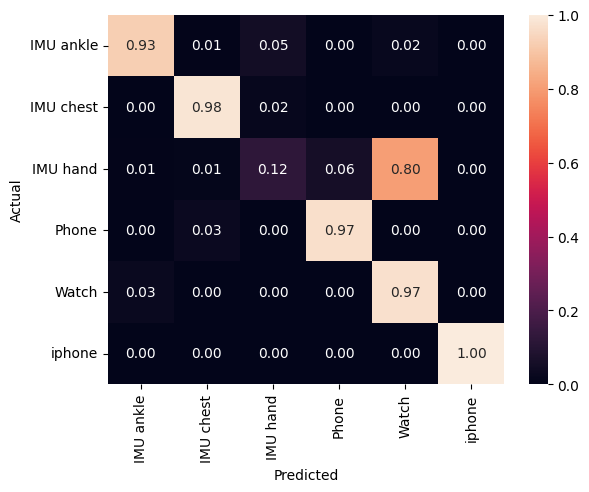

In [5]:
plt.plot(LSTMCNN_history.history['categorical_accuracy'], label='accuracy')
plt.plot(LSTMCNN_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_LSTMCNN_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_LSTMCNN_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)